In [1]:
import os
import numpy as np
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
with zipfile.ZipFile('archive.zip','r') as f:
    f.extractall('archive')

In [2]:
crops = ['jute','maize','rice','sugarcane','wheat']
path = 'archive/kag2'

In [3]:
img_height = 256 
img_width = 256
batch_size = 16
def load_data(path,dataset):
    data = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = 0.2,
        subset = dataset,
        batch_size=batch_size, 
        image_size=(img_height,img_width),
        shuffle=True, seed=0
    )
    return data


In [4]:
train = load_data(path,'training')

class_names = train.class_names

Found 854 files belonging to 5 classes.
Using 684 files for training.


In [5]:
dev = load_data(path,'validation')

Found 854 files belonging to 5 classes.
Using 170 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dev = dev.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
num_classes = 5
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu',
               kernel_regularizer = tf.keras.regularizers.L2(0.1),
               activity_regularizer = tf.keras.regularizers.L2(0.01)),
  layers.Dense(num_classes,
               kernel_regularizer = tf.keras.regularizers.L2(0.1),
               activity_regularizer = tf.keras.regularizers.L2(0.01)),
  
])


In [10]:
model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0

In [22]:
epochs = 30
history = model.fit(
    train,
    validation_data = dev,
    epochs = epochs
)

Epoch 1/30
43/43 [==============================] - 3s 69ms/step - loss: 1.1806 - accuracy: 1.0000 - val_loss: 1.3965 - val_accuracy: 0.9000
Epoch 2/30
43/43 [==============================] - 3s 69ms/step - loss: 1.1314 - accuracy: 1.0000 - val_loss: 1.3467 - val_accuracy: 0.8941
Epoch 3/30
43/43 [==============================] - 3s 69ms/step - loss: 1.0877 - accuracy: 1.0000 - val_loss: 1.3033 - val_accuracy: 0.9118
Epoch 4/30
43/43 [==============================] - 3s 69ms/step - loss: 1.0500 - accuracy: 1.0000 - val_loss: 1.2680 - val_accuracy: 0.9000
Epoch 5/30
43/43 [==============================] - 3s 68ms/step - loss: 1.0162 - accuracy: 1.0000 - val_loss: 1.2395 - val_accuracy: 0.8882
Epoch 6/30
43/43 [==============================] - 3s 69ms/step - loss: 0.9867 - accuracy: 1.0000 - val_loss: 1.2122 - val_accuracy: 0.8882
Epoch 7/30
43/43 [==============================] - 3s 69ms/step - loss: 0.9593 - accuracy: 1.0000 - val_loss: 1.1887 - val_accuracy: 0.8941
Epoch 8/30
43

In [23]:
acc = history.history['accuracy']
dev_acc = history.history['val_accuracy']
loss = history.history['loss']
dev_loss = history.history['val_loss']
epochs_range = range(epochs)


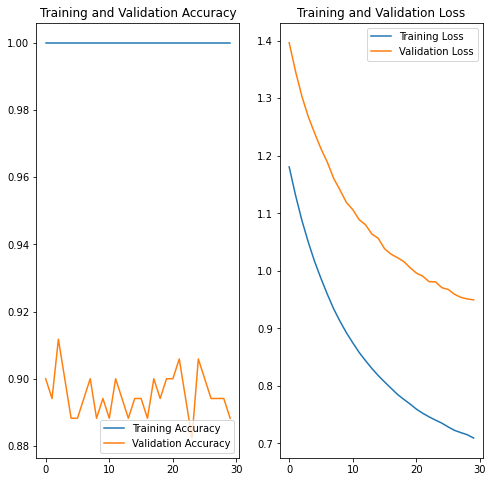

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, dev_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, dev_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [25]:
label_class = {}
for i,label in enumerate(class_names):
    label_class[label] = i

In [26]:
def test_model(image_path):
    img = tf.keras.preprocessing.image.load_img(
            image_path,
            target_size = (img_height,img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_tensor = tf.expand_dims(img_array, 0)
    pred = model.predict(img_tensor)
    score = tf.nn.softmax(pred)
    class_name = class_names[np.argmax(score)]
    confidence = 100*np.max(score)
    pred_label = label_class[class_name]
    return class_name,confidence,pred_label

In [27]:
test_data = pd.read_csv('archive_test/testdata.csv').iloc[:,1:]

In [28]:
path_kaggle = '/kaggle/input/testssss/test_crop_image/'
path_test_data = []
for i in test_data['testpath']:
    path_test_data.append(os.path.relpath(i,path_kaggle))
test_data['image'] = path_test_data

In [29]:
with zipfile.ZipFile('archive_test.zip','r') as f_t:
    f_t.extractall('archive_test')
path_test = 'archive_test/test_crop_image'

In [30]:
test_list = []
for test_file in path_test_data:
    class_name,percentage,label = test_model(os.path.join(path_test,test_file))
    test_list.append(label)

In [31]:
test_data['pred'] = test_list
y_true = test_data['croplabel']
y_pred = test_data['pred']
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true,y_pred)
acc*100

52.94117647058824